<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/trend_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTRODUCCIÓN

¿Es posible desarrollar un detector de tendencias sólo con un indicador y clusterización?

Se va a comprobar si es posible con el Williams %R, que no es más que una normalización del precio.

La hipótesis es que si el indicador tiene la mínima capacidad predictiva, con la generación de 2 clústers obtendremos un clúster que se identifica con las tendencias alcistas y otro con las tendencias bajistas.

Para comprobarlo se realizarán los siguientes pasos:

1) cálculo del Williams %R para un rango de parámetros a modo de variables

2) generación de 2 clústers con K-Means en el periodo de entrenamiento

3) comprobación en forward

Se utilizarán los siguientes periodos:

- train: 01/01/2010 -01/01/2020
- forward: 01/01/2020 - 01/01/2023

#ENTORNO

##DATOS

El activo utilizado en este código será el EURUSD en diario disponible en los siguientes enlaces:

- descarga: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ

- visualización: https://drive.google.com/file/d/1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ/view?usp=sharing

##LIBRERÍAS

In [ ]:
#INSTALACIÓN DE LIBRERÍA PARA CALCULAR INDICADORES TÉCNICOS
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=ea3e490cde6a1b75df5878763c27832982fdd45e0443d28d2f1deb530b4bf275
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#IMPORTACIÓN DE LIBRERÍAS
import pandas_ta as ta
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import date
from scipy.stats import ks_2samp
import warnings
warnings.filterwarnings('ignore')

##FUNCIONES

In [ ]:
#FUNCIÓN PARA OBTENER LOS DATOS

def get_data(url):
  """
  Descarga un archivo CSV desde una URL y devuelve los datos como un DataFrame.

  Parámetros:
  url (str): La URL del archivo CSV a descargar.

  Retorna:
  pandas.DataFrame: Un DataFrame que contiene los datos del archivo CSV.
  """

  #Descargar el archivo
  output = "archivo.csv"
  gdown.download(url, output, quiet=False)

  #Leer el archivo descargado
  data = pd.read_csv(output)

  return data

In [ ]:
#FUNCIÓN PARA CALCULAR WILLIAMS

def calculate_williams(data):
  """
  Calcula Williams %R para un rango de parámetros para los datos de precios de un activo específico.

  Args:
    data (pandas.DataFrame): Datos históricos del activo.

  Returns:
    pandas.DataFrame: Un DataFrame que contiene los indicadores calculados.
  """

  #Renombrar las columnas
  data.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
  #Establecer la fecha como índice
  data = data.set_index("Date")
  #Eliminar columnas innecesarias
  data = data.drop(["Time", "Volume"], axis=1)

  #Extraer columnas necesarias para el cálculo de indicadores
  close = data["Close"]
  high = data["High"]
  low = data["Low"]

  #Crear de listas para guardar el nombre de los indicadores y los valores
  indicators = []
  columns = []

  #Establecer rango de valores usados como parámetro para el cálculo de los indicadores
  periods = list(range(5,100))

  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    indicators.append(ta.willr(high, low, close, n))
    columns.append(name)

  #Crear dataframe con todos los indicadores calculados
  df = pd.concat(indicators, axis=1)
  df.columns = columns
  df.index = data.index

  #Calcular el retorno a un día vista
  df["Open"] = data["Open"]
  df["Close"] = data["Close"]
  df["Return"] = df["Open"].pct_change().shift(-1)
  df = df.drop("Open", axis=1)

  #Eliminar las filas con valores faltantes
  df = df.dropna()

  return df

In [ ]:
#FUNCIÓN PARA LA PARTICIÓN EN TRAIN, TEST Y FORWARD

def split(data):
  """
  Divide los datos en conjuntos de entrenamiento y forward.

  Args:
    data (pandas.DataFrame): DataFrame que contiene los datos a dividir.

  Returns:
    tuple: Una tupla que contiene los siguientes conjuntos de datos:
      - train (pandas.DataFrame): Conjunto de entrenamiento.
      - forward (pandas.DataFrame): Conjunto forward.
  """

  #Definir datos de entrenamiento
  train = data.loc["2010.01.01":"2012.01.01", :]

  #Definir forward
  forward = data.loc["2020.01.01":"2023.01.01", :]

  return train, forward

#DATASET

In [ ]:
#GENERACIÓN DEL DATASET

#Obtener datos
data = get_data("https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ")

#Calcular indicadores
data = calculate_williams(data)

#Realizar particiones
train, forward = split(data)

forward.head(5)

Downloading...
From: https://drive.google.com/uc?id=1inRqthKmwbzhzgXdv9FbpEvp8gRA5RnQ
To: /content/archivo.csv
100%|██████████| 779k/779k [00:00<00:00, 65.6MB/s]


,WILLR5,WILLR6,WILLR7,WILLR8,WILLR9,WILLR10,WILLR11,WILLR12,WILLR13,WILLR14,...,WILLR92,WILLR93,WILLR94,WILLR95,WILLR96,WILLR97,WILLR98,WILLR99,Close,Return
Date,,,,,,,,,,,,,,,,,,,,,
2020.01.01,-16.391185,-15.139949,-13.983549,-13.983549,-13.983549,-13.757225,-13.757225,-13.757225,-13.757225,-13.757225,...,-6.607440,-6.607440,-6.607440,-6.607440,-6.607440,-6.607440,-6.607440,-6.607440,1.12154,-0.000312
2020.01.02,-96.433289,-50.275482,-46.437659,-42.890717,-42.890717,-42.890717,-42.196532,-42.196532,-42.196532,-42.196532,...,-20.266519,-20.266519,-20.266519,-20.266519,-20.266519,-20.266519,-20.266519,-20.266519,1.11662,-0.004191
2020.01.03,-62.959720,-62.959720,-49.517906,-45.737913,-42.244418,-42.244418,-42.244418,-41.560694,-41.560694,-41.560694,...,-19.961133,-19.961133,-19.961133,-19.961133,-19.961133,-19.961133,-19.961133,-19.961133,1.11673,0.000099
2020.01.04,-73.029772,-73.029772,-73.029772,-57.438017,-53.053435,-49.001175,-49.001175,-49.001175,-48.208092,-48.208092,...,-23.153803,-23.153803,-23.153803,-23.153803,-23.153803,-23.153803,-23.153803,-23.153803,1.11558,-0.000242
2020.01.06,-28.663793,-42.031524,-42.031524,-42.031524,-33.057851,-30.534351,-28.202115,-28.202115,-28.202115,-27.745665,...,-13.325930,-13.325930,-13.325930,-13.325930,-13.325930,-13.325930,-13.325930,-13.325930,1.11912,0.002383


#CLUSTERING

In [ ]:
#GENERACIÓN DE CLÚSTERS

#Preparar datos de entrenamiento
X_train = train.iloc[:,:-2]

#Preparar datos forward
X_forward = forward.iloc[:,:-2]

#Aplicar K-Means
kmeans = KMeans(n_clusters=2).fit(X_train)
predictions = kmeans.predict(X_forward)

#Generar predicciones en forward
df_forward = pd.DataFrame(forward["Return"])
df_forward["Pred"] = predictions
df_forward["Close"] = forward["Close"]
df_forward.head(5)

,Return,Pred,Close
Date,,,
2020.01.01,-0.000312,0,1.12154
2020.01.02,-0.004191,0,1.11662
2020.01.03,0.000099,0,1.11673
2020.01.04,-0.000242,0,1.11558
2020.01.06,0.002383,0,1.11912


In [ ]:
#COMPROBACIÓN DE CLÚSTERS

#Calcular retornos medios del clúster con la etiqueta 0
ave_zero = np.mean(df_forward[df_forward["Pred"]==0]["Return"])
print("Retorno medio de la etiqueta 0:", round(ave_zero, 4))

#Calcular retornos medios del clúster con la etiqueta 1
ave_one = np.mean(df_forward[df_forward["Pred"]==1]["Return"])
print("Retorno medio de la etiqueta 1:", round(ave_one, 4))

Retorno medio de la etiqueta 0: 0.0011
Retorno medio de la etiqueta 1: -0.0008


In [ ]:
#RENOMBRADO DE LAS ETIQUETAS OTORGADAS POR K-MEANS EN 1 O -1

#Renombrar etiquetas
if ave_zero > ave_one:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, 1, -1)
else:
  df_forward["Pred"] = np.where(df_forward["Pred"]==0, -1, 1)

In [ ]:
#FORMATO DE FECHAS
dates = pd.to_datetime(df_forward.index)
df_forward.set_index(dates, inplace=True)

#COMPROBACIONES

##GRÁFICO

Graficando la evolución del precio pintando cada punto según el clúster podremos comprobar si se distinguen tendencias alcistas y bajistas.

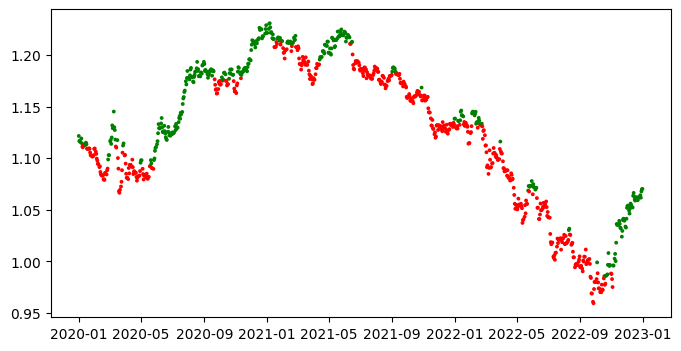

In [ ]:
#GRÁFICO CON LAS PREDICCIONES

#Crear una lista de colores según predicción
colors = ['green' if c == 1 else 'red' for c in df_forward["Pred"]]

#Crear el gráfico
plt.figure(figsize=(8, 4))
plt.scatter(df_forward.index, df_forward["Close"], c=colors, s=3)
plt.show()

##HISTOGRAMAS

Superponiendo el histograma de los retornos correspondientes a cada clúster podremos comprobar las diferencias entre cada clúster.

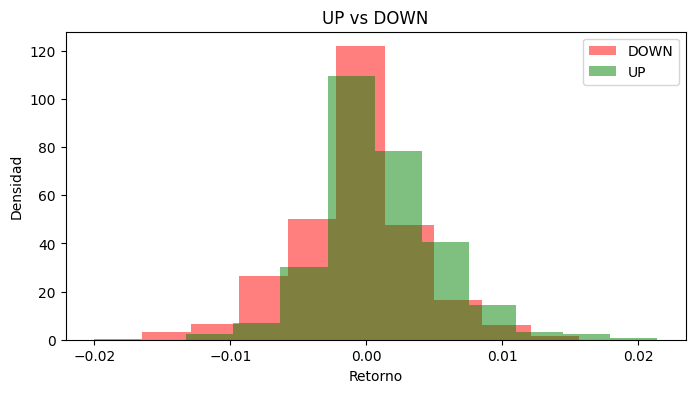

In [ ]:
#HISTOGRAMAS SUPERPUESTOS DE LOS RETORNOS DE LOS CLÚSTERS

#Generar histogramas
plt.figure(figsize=(8, 4))
plt.hist(df_forward[df_forward["Pred"]==-1]["Return"], density=True, alpha=0.5, color="red", label="DOWN")
plt.hist(df_forward[df_forward["Pred"]==1]["Return"], density=True, alpha=0.5, color="green", label="UP")
plt.xlabel("Retorno")
plt.ylabel("Densidad")
plt.title("UP vs DOWN")
plt.legend()
plt.show()

##TEST ESTADÍSTICO

Realizando el test de Kolmogorov-Smirnov podremos confirmar si los clústers son significativamente diferentes: el estadístico nos mostrará la magnitud de la diferencia y el p_value la fiabilidad del test.

In [ ]:
#TEST DE KOLMOGOROV-SMIRNOV

#Aplicar test de Kolmogorov-Smirnov
statistic, p_value = ks_2samp(df_forward.loc[df_forward["Pred"] == 1, "Return"],
                              df_forward.loc[df_forward["Pred"] == -1, "Return"])

print("Estadístico:", statistic)
print("P_value:", p_value)

Estadístico: 0.1874043132288733
P_value: 1.9892925878260646e-07


#CONCLUSIÓN

Se ha podido comprobar visual y estadísticamente que un único indicador es suficiente para distinguir tendencias con clusterización.
